# Learning PyMatgen, Atomate, Fireworks and VASP: Welcome Guide

###### Guide by Martin Siron, some code adapted from John Dagdelen

### Let's make a material: ZnTe

Lets start with the import we might need

In [1]:
from pymatgen import Structure, MPRester, Lattice, Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

We can get a material from the Materials Project Database such as ZnTe:

In [2]:
mpr=MPRester()
znte_mp = SpacegroupAnalyzer(mpr.get_structure_by_material_id("mp-2176")).get_conventional_standard_structure()

We can print out this structure to see what it looks like:

In [3]:
znte_mp

Structure Summary
Lattice
    abc : 6.184826420366441 6.184826420366441 6.184826420366441
 angles : 90.0 90.0 90.0
 volume : 236.58246172098217
      A : 6.184826420366441 0.0 3.787113939491872e-16
      B : 9.94595945090975e-16 6.184826420366441 3.787113939491872e-16
      C : 0.0 0.0 6.184826420366441
PeriodicSite: Zn (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Zn (0.0000, 3.0924, 3.0924) [0.0000, 0.5000, 0.5000]
PeriodicSite: Zn (3.0924, 0.0000, 3.0924) [0.5000, 0.0000, 0.5000]
PeriodicSite: Zn (3.0924, 3.0924, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Te (4.6386, 4.6386, 4.6386) [0.7500, 0.7500, 0.7500]
PeriodicSite: Te (4.6386, 1.5462, 1.5462) [0.7500, 0.2500, 0.2500]
PeriodicSite: Te (1.5462, 4.6386, 1.5462) [0.2500, 0.7500, 0.2500]
PeriodicSite: Te (1.5462, 1.5462, 4.6386) [0.2500, 0.2500, 0.7500]

We can also create the same structure manually

In [4]:
znte_lattice = Lattice.cubic(6.184826420366441)
species = ["Zn", "Zn","Zn","Zn","Te","Te","Te","Te"]
coordinates = [[0,0,0], [0,0.5,0.5],[0.5,0,0.5],
               [0.5,0.5,0],[.75,.75,.75],[.75,.25,.25],
               [0.25,0.75,0.25],[0.25,0.25,0.75]]
znte = Structure(znte_lattice,species=species,coords=coordinates)

In [5]:
znte

Structure Summary
Lattice
    abc : 6.184826420366441 6.184826420366441 6.184826420366441
 angles : 90.0 90.0 90.0
 volume : 236.58246172098217
      A : 6.184826420366441 0.0 0.0
      B : 0.0 6.184826420366441 0.0
      C : 0.0 0.0 6.184826420366441
PeriodicSite: Zn (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Zn (0.0000, 3.0924, 3.0924) [0.0000, 0.5000, 0.5000]
PeriodicSite: Zn (3.0924, 0.0000, 3.0924) [0.5000, 0.0000, 0.5000]
PeriodicSite: Zn (3.0924, 3.0924, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Te (4.6386, 4.6386, 4.6386) [0.7500, 0.7500, 0.7500]
PeriodicSite: Te (4.6386, 1.5462, 1.5462) [0.7500, 0.2500, 0.2500]
PeriodicSite: Te (1.5462, 4.6386, 1.5462) [0.2500, 0.7500, 0.2500]
PeriodicSite: Te (1.5462, 1.5462, 4.6386) [0.2500, 0.2500, 0.7500]

We have a structure now, that is all we need for a quick VASP calculation to determine if this stucture is stable

### Ex1: Lets do our first VASP!

For VASP to run we need to provide 4 input files:
- POSCAR: this is the structure file
- INCAR: this is the parameter of the calculation
- POTCAR: this is the details about the potentials/elements to calculated the various forces
- KPOINTS: this is the mesh needed to figure out how detailed your calculations might need to be

Let's start by using PyMatgen to make a POSCAR from our structure

In [6]:
from pymatgen.io.vasp.inputs import Kpoints, Poscar, Potcar, Incar
POSCAR = Poscar(znte)

Now lets make our KPOINTS. This defined how detailed we want the mesh

In [7]:
grid = (6,6,6)
KPOINTS = Kpoints.monkhorst_automatic(kpts=grid)

Now let's set our basic INCAR parameters:

In [8]:
incar_params = {"EDIFF" : 0.0004, #this sets the tolerance between steps before stoping the simulation
                "EDIFFG" : -0.01, #this sets the tolerance between steps before stoping the simulation
                "ENCUT" : 350, #the maximum energy of a planewave considered in a calculation
                "IBRION" : 1, #IBRION = 1 if we know this structure is close to the stable structure
                "ISIF" : 3, #ISIF = 3: allow for complete structure optimization
                "ISMEAR" : 0, #what kind of smearing; 0=Gaussian
                "SIGMA" : 0.2, #width of smearing
                "NSW" : 15, #max # of ionic steps between iterations, more leads to more accuracy but longer time
                "NBANDS" : 8, #number of e- bands to consider in calculation, for large supercell, leave this blank
                "LREAL" : "False"} #for large super cell, set to "AUTO", whether or not to use real/reciprocal projections

In [9]:
INCAR = Incar.from_dict(incar_params)

POTCARS are commercially available files from VASP that details the potential for specific elements.
You should concatenate all the POTCARs into one file named POTCAR into the same directory...

#### Lets write the input files

In [120]:
def write_input_set(POSCAR, INCAR, KPOINTS, directory="new_input_set"):
    import os
    try:
        os.mkdir(directory)
    except FileExistsError: None
    
    POSCAR.write_file("{}/POSCAR".format(directory))
    INCAR.write_file("{}/INCAR".format(directory))
    KPOINTS.write_file("{}/KPOINTS".format(directory))
    print("Input set written to '{}'".format(directory))

In [11]:
directory = "Example01"
write_input_set(POSCAR,INCAR, KPOINTS, directory)

Input set written to 'Example01'


Now, make sure you have the POTCARs in the directory and you're ready to run VASP in that directory!

Once you run that code, its time to check the results. If successful, they should be in an OUTCAR file. I put a sample one in there for the purpose of this demonstation.

In [114]:
from pymatgen.io.vasp.outputs import Outcar
OUTCAR = Outcar("Example01/OUTCAR")
OUTCAR.final_energy

-15.55474432

It is standard to normalize this by atoms:

In [118]:
OUTCAR.final_energy/znte.num_sites

-1.94434304

### Lets do kpoints and $En_{cut}$ convergence tests

Traditionally, we might not know what kpoints and Ecut values to use, so we should do convergence tests!

In [110]:
kpoints = range(3,10) #we can start at 3 since 1/2 is def too small.

In [122]:
for k in kpoints:
    KPOINTS = Kpoints.monkhorst_automatic(kpts=(k,k,k)) #You might not want a cubic kpoints grid, but since our structure is cubic, this is a good bet
    directory = "Example01/kpoints_conv/kpts_{}".format(k)
    write_input_set(POSCAR,INCAR, KPOINTS, directory) #all our other parameters stay the same.

Input set written to 'Example01/kpoints_conv/kpts_3'
Input set written to 'Example01/kpoints_conv/kpts_4'
Input set written to 'Example01/kpoints_conv/kpts_5'
Input set written to 'Example01/kpoints_conv/kpts_6'
Input set written to 'Example01/kpoints_conv/kpts_7'
Input set written to 'Example01/kpoints_conv/kpts_8'
Input set written to 'Example01/kpoints_conv/kpts_9'


For the purpose of this demonstrations I populated the directories with OUTCAR files. Lets look at how our kpoints converge!

In [123]:
es_k = []
for k in kpoints:
    OUTCAR = Outcar("Example01/kpoints_conv/kpts_{}/OUTCAR".format(k))
    es_k.append(OUTCAR.final_energy/znte.num_sites)

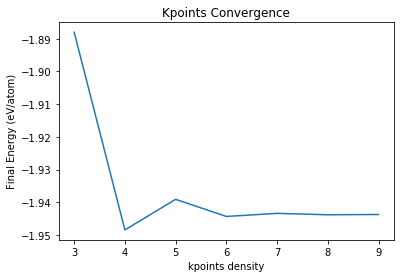

In [127]:
import matplotlib.pyplot as plt
plt.plot(kpoints,es_k)
plt.title("Kpoints Convergence")
plt.ylabel("Final Energy (eV/atom)")
plt.xlabel("kpoints density")
plt.show()

Lets look at how our two last energies compare in values:

In [132]:
es_k[len(es_k)-1]-es_k[len(es_k)-2]

8.387624999994792e-05

This is pretty good convergence, now do the same for Encut

In [133]:
# Your code here

### Let's use Atomate, Fireworks to do the same thing!

In [20]:
from atomate.vasp.workflows.base import core, library

In [21]:
wf = core.get_wf(znte, "optimize_only.yaml") 

This creates a simple workflow object which simply optimizes the structure, same as what our VASP calculation will do

In [28]:
len(wf.fws) #We can check how many 'fireworks' are in this workflow:

1

In [44]:
len(wf.fws[0].spec["_tasks"]) #We can check how many tasks are in this firework:

4

In [45]:
type(wf.fws[0]) #We can also check what kind of object this Firetask is:

atomate.vasp.fireworks.core.OptimizeFW

Looks like there are 4 tasks in this OptimizeFW object, lets see if we can identify what they are!

In [86]:
for task in wf.fws[0].tasks:
    print(task.__class__)

<class 'atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet'>
<class 'atomate.vasp.firetasks.run_calc.RunVaspCustodian'>
<class 'atomate.common.firetasks.glue_tasks.PassCalcLocs'>
<class 'atomate.vasp.firetasks.parse_outputs.VaspToDb'>


From this we can see what is happening behind the scene in this FireTask. First the VASP files are written.
Second, VASP is run. Third, some parameters are looked up, and last, these parameters are written to the Mongo DB

Lets look in depth in the first task and see if we can write the VASP files out locally to compare to the VASP files from previous calculations

In [98]:
wf.fws[0].tasks[0]["vasp_input_set"]

MPRelaxSet

We see that the firetask vasp_input_set is the MPRelaxSet. This class can be used to locally write the files.

In [99]:
from pymatgen.io.vasp.sets import MPRelaxSet

MPRelaxSet takes a structure

In [101]:
type(wf.fws[0].tasks[0]["structure"])

pymatgen.core.structure.Structure

In [103]:
from atomate.vasp.firetasks.write_inputs import WriteVaspFromIOSet
mprs = MPRelaxSet(wf.fws[0].tasks[0]["structure"])

We can now write this structure locally to a file

In [104]:
mprs.write_input("Example02")

Note, that I deleted the POTCAR file for proprietary reason, lets start to look into the various files

In [106]:
incar2 = Incar.from_file("Example02/INCAR")

In [107]:
incar2.as_dict()

{'ALGO': 'Fast',
 'EDIFF': 0.0004,
 'ENCUT': 520,
 'IBRION': 2,
 'ICHARG': 1,
 'ISIF': 3,
 'ISMEAR': -5,
 'ISPIN': 2,
 'LORBIT': 11,
 'LREAL': 'Auto',
 'LWAVE': False,
 'MAGMOM': [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
 'NELM': 100,
 'NSW': 99,
 'PREC': 'Accurate',
 'SIGMA': 0.05,
 '@module': 'pymatgen.io.vasp.inputs',
 '@class': 'Incar'}

From this we can see our EDIFF, was about the only thing that was the same. Perhaps start to delve into what some of these values mean from this website: https://cms.mpi.univie.ac.at/wiki/index.php/Category:INCAR

Lets look at the KPOINTS file:

In [108]:
kpoints2 = Kpoints.from_file("Example02/KPOINTS")

In [204]:
kpoints2.as_dict()

{'comment': 'Automatic kpoint scheme',
 'nkpoints': 0,
 'generation_style': 'Monkhorst',
 'kpoints': [[4, 4, 4]],
 'usershift': (0, 0, 0),
 'kpts_weights': None,
 'coord_type': None,
 'labels': None,
 'tet_number': 0,
 'tet_weight': 0,
 'tet_connections': None,
 '@module': 'pymatgen.io.vasp.inputs',
 '@class': 'Kpoints'}

Looks like they decided to go for a 4x4x4 grid.

In [171]:
#We can also look at the input without writing to a file!
mprs.get_vasp_input()

{'INCAR': {'ALGO': 'Fast',
  'EDIFF': 0.0004,
  'ENCUT': 520,
  'IBRION': 2,
  'ICHARG': 1,
  'ISIF': 3,
  'ISMEAR': -5,
  'ISPIN': 2,
  'LORBIT': 11,
  'LREAL': 'Auto',
  'LWAVE': False,
  'NELM': 100,
  'NSW': 99,
  'PREC': 'Accurate',
  'SIGMA': 0.05,
  'MAGMOM': [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]},
 'KPOINTS': pymatgen 4.7.6+ generated KPOINTS with grid density = 537 / atom
 0
 Monkhorst
 4 4 4,
 'POSCAR': Zn4 Te4
 1.0
 6.184826 0.000000 0.000000
 0.000000 6.184826 0.000000
 0.000000 0.000000 6.184826
 Zn Te
 4 4
 direct
 0.000000 0.000000 0.000000 Zn
 0.000000 0.500000 0.500000 Zn
 0.500000 0.000000 0.500000 Zn
 0.500000 0.500000 0.000000 Zn
 0.750000 0.750000 0.750000 Te
 0.750000 0.250000 0.250000 Te
 0.250000 0.750000 0.250000 Te
 0.250000 0.250000 0.750000 Te,
 'POTCAR': [<pymatgen.io.vasp.inputs.PotcarSingle at 0x2aaadef25e80>,
  <pymatgen.io.vasp.inputs.PotcarSingle at 0x2aaadef25b38>]}

Lets start to look at what the fireworks might be looking for!

In [146]:
task = wf.fws[0].tasks[3]

In [205]:
task.as_dict()["additional_fields"]

{'task_label': 'structure optimization'}

Looks like there is no extra arguments to parse, lets see whats always parsed to the DB [NOT SURE IF THIS IS ACCURATE]

In [210]:
from atomate.vasp.drones import VaspDrone
VaspDrone.schema["output"]

{'bandgap',
 'cbm',
 'density',
 'energy',
 'energy_per_atom',
 'forces',
 'is_gap_direct',
 'is_metal',
 'spacegroup',
 'stress',
 'structure',
 'vbm'}

### Let's repeat but with a more advanced workflow!

This section could really use more help!! please contribute

In [211]:
#If you remember:
type(wf.fws[0])

atomate.vasp.fireworks.core.OptimizeFW

Instead of recreating a workflow, lets get one directly from the library:

In [212]:
from atomate.vasp.fireworks import core

In [241]:
fireworks = [x[1] for x in inspect.getmembers(core)]

In [248]:
for firework in fireworks:
    if "FW" in str(firework):
        print(firework)

<class 'atomate.vasp.fireworks.core.BoltztrapFW'>
<class 'atomate.vasp.fireworks.core.DFPTFW'>
<class 'atomate.vasp.fireworks.core.HSEBSFW'>
<class 'atomate.vasp.fireworks.core.LepsFW'>
<class 'atomate.vasp.fireworks.core.MDFW'>
<class 'atomate.vasp.fireworks.core.NEBFW'>
<class 'atomate.vasp.fireworks.core.NEBRelaxationFW'>
<class 'atomate.vasp.fireworks.core.NonSCFFW'>
<class 'atomate.vasp.fireworks.core.OptimizeFW'>
<class 'atomate.vasp.fireworks.core.RamanFW'>
<class 'atomate.vasp.fireworks.core.SOCFW'>
<class 'atomate.vasp.fireworks.core.StaticFW'>
<class 'atomate.vasp.fireworks.core.StaticInterpolateFW'>
<class 'atomate.vasp.fireworks.core.TransmuterFW'>


Lets chose a fireworks class...how about Raman?

In [249]:
from atomate.vasp.fireworks.core import RamanFW

In [341]:
rwf = raman.get_wf_raman_spectra(znte)

Lets look at the tasks associated with this firework!

In [290]:
for firetask in rwf.fws:
    print(firetask.name)
    for task in firetask.tasks:
        print(task.__class__)
    print()

ZnTe-structure optimization
<class 'atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet'>
<class 'atomate.vasp.firetasks.run_calc.RunVaspCustodian'>
<class 'atomate.common.firetasks.glue_tasks.PassCalcLocs'>
<class 'atomate.vasp.firetasks.parse_outputs.VaspToDb'>

ZnTe-static dielectric
<class 'atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs'>
<class 'atomate.vasp.firetasks.write_inputs.WriteVaspStaticFromPrev'>
<class 'atomate.vasp.firetasks.run_calc.RunVaspCustodian'>
<class 'atomate.common.firetasks.glue_tasks.PassResult'>
<class 'atomate.common.firetasks.glue_tasks.PassCalcLocs'>
<class 'atomate.vasp.firetasks.parse_outputs.VaspToDb'>

ZnTe-raman_0_-0.005
<class 'atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs'>
<class 'atomate.vasp.firetasks.write_inputs.WriteVaspStaticFromPrev'>
<class 'atomate.vasp.firetasks.write_inputs.WriteNormalmodeDisplacedPoscar'>
<class 'atomate.vasp.firetasks.run_calc.RunVaspCustodian'>
<class 'atomate.common.firetasks.glue_tasks.PassResult'>
<cla

Knowing that the RamanFW class takes two inputs: the raman mode, and displacement, we can start to see whats happening. The first firetask simply optimizes the structure like previously. The second, takes the optimize structure 

Looks like the first tasks takes a contcar from a previous calculation and turns it back into a POSCAR. We can skip this step, since we have our POSCAR. A CONTCAR is the result of a structural optimization VASP

In [293]:
rwf.fws[1].spec

{'_tasks': [{'calc_loc': True,
   'contcar_to_poscar': True,
   '_fw_name': '{{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}}'},
  {'lepsilon': True,
   'other_params': {'user_incar_settings': {}, 'force_gamma': True},
   '_fw_name': '{{atomate.vasp.firetasks.write_inputs.WriteVaspStaticFromPrev}}'},
  {'vasp_cmd': 'vasp',
   '_fw_name': '{{atomate.vasp.firetasks.run_calc.RunVaspCustodian}}'},
  {'pass_dict': {'structure': 'a>>final_structure',
    'eigenvals': 'a>>normalmode_eigenvals',
    'eigenvecs': 'a>>normalmode_eigenvecs'},
   'calc_dir': '.',
   'parse_kwargs': {'filename': 'vasprun.xml.gz',
    'parse_eigen': True,
    'parse_dos': False},
   'parse_class': 'pymatgen.io.vasp.outputs.Vasprun',
   'mod_spec_key': 'normalmodes',
   '_fw_name': '{{atomate.common.firetasks.glue_tasks.PassResult}}'},
  {'name': 'static dielectric',
   '_fw_name': '{{atomate.common.firetasks.glue_tasks.PassCalcLocs}}'},
  {'db_file': None,
   'additional_fields': {'task_label': 'static dielectr

In [294]:
from atomate.vasp.firetasks.write_inputs import WriteVaspStaticFromPrev

From exploring the class called in the 2nd task, we can see that it deals with the MPStaticSet class

In [295]:
from pymatgen.io.vasp.sets import MPStaticSet

In [302]:
#We will load the structure from the optimized CONTCAR
mpss = MPStaticSet(Structure.from_file("Example01/CONTCAR"),lepsilon=True)

In [303]:
#We can get the parameters for such a calculation and compare them to a standard optimize calculation
mpss.get_vasp_input()
#We can see EDIFF is much lower, and the kpoints is much denser

{'INCAR': {'ALGO': 'Normal',
  'EDIFF': 0.00030000000000000003,
  'ENCUT': 520,
  'IBRION': 8,
  'ICHARG': 0,
  'ISIF': 3,
  'ISMEAR': -5,
  'ISPIN': 2,
  'LORBIT': 11,
  'LREAL': 'Auto',
  'LWAVE': False,
  'NELM': 100,
  'PREC': 'Accurate',
  'SIGMA': 0.05,
  'MAGMOM': [0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
  'LAECHG': True,
  'LCHARG': True,
  'LVHAR': True,
  'LEPSILON': True,
  'LPEAD': True},
 'KPOINTS': pymatgen 4.7.6+ generated KPOINTS with grid density = 842 / atom
 0
 Gamma
 7 7 2,
 'POSCAR': Zn3 Te3
 1.0
 4.370109 -0.006366 -0.001904
 -2.190567 3.781672 0.001857
 -0.004661 0.002558 10.699412
 Zn Te
 3 3
 direct
 0.355137 0.017307 0.026508 Zn
 0.661980 0.644873 0.693176 Zn
 0.982643 0.338052 0.359851 Zn
 0.019124 0.349090 0.110159 Te
 0.330191 0.980879 0.776817 Te
 0.650924 0.669799 0.443489 Te,
 'POTCAR': [<pymatgen.io.vasp.inputs.PotcarSingle at 0x2aaae1578d68>,
  <pymatgen.io.vasp.inputs.PotcarSingle at 0x2aaae1578978>]}

In [304]:
rwf.fws[2].spec

{'_tasks': [{'calc_loc': True,
   'contcar_to_poscar': True,
   '_fw_name': '{{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}}'},
  {'lepsilon': True,
   'other_params': {'user_incar_settings': {}},
   '_fw_name': '{{atomate.vasp.firetasks.write_inputs.WriteVaspStaticFromPrev}}'},
  {'mode': 0,
   'displacement': -0.005,
   '_fw_name': '{{atomate.vasp.firetasks.write_inputs.WriteNormalmodeDisplacedPoscar}}'},
  {'vasp_cmd': 'vasp',
   '_fw_name': '{{atomate.vasp.firetasks.run_calc.RunVaspCustodian}}'},
  {'pass_dict': {'mode': 0,
    'displacement': -0.005,
    'epsilon': 'a>>epsilon_static'},
   'calc_dir': '.',
   'parse_kwargs': {'filename': 'vasprun.xml.gz',
    'parse_eigen': True,
    'parse_dos': False},
   'parse_class': 'pymatgen.io.vasp.outputs.Vasprun',
   'mod_spec_key': 'raman_epsilon->0_m0d005',
   '_fw_name': '{{atomate.common.firetasks.glue_tasks.PassResult}}'},
  {'name': 'raman_0_-0.005',
   '_fw_name': '{{atomate.common.firetasks.glue_tasks.PassCalcLocs}}'},
  {'

In [305]:
#We can see that after the StaticSet, the POSCAR is modified by the function below but with eigenvalues parsed theough to the function
from atomate.vasp.firetasks.write_inputs import WriteNormalmodeDisplacedPoscar

In [307]:
k = WriteNormalmodeDisplacedPoscar(mode=0,displacement=0.005)

In [335]:
#I'm going to create a random value for these just to be able to see whats happening with the task. 
fw_spec = {"normalmodes":{"eigenvecs":[[[1,2,3],[2,1,3],[2,1,3]],
                                       [[1,2,3],[2,1,3],[2,1,3]],
                                       [[1,2,3],[2,1,3],[2,1,3]],
                                       [[1,2,3],[2,1,3],[2,1,3]]]}}

We can then run this task on a POSCAR to see how it changes...

In [338]:
WriteNormalmodeDisplacedPoscar(mode=0,displacement=0.005).run_task(fw_spec)

After it looks like vasp is run, and then certain args are passed to the DB...

To launch this workflow to a launchpad, just follow the command:

In [343]:
from fireworks import LaunchPad
lpad = LaunchPad.auto_load()
lpad.add_wf(rwf)

2019-05-02 16:55:34,972 INFO Added a workflow. id_map: {-211: 66, -210: 67, -209: 68, -208: 69, -207: 70, -206: 71, -205: 72, -204: 73, -203: 74, -202: 75, -201: 76, -200: 77, -199: 78, -198: 79, -197: 80, -196: 81, -195: 82, -194: 83, -193: 84, -192: 85, -191: 86, -190: 87, -189: 88, -188: 89, -187: 90, -186: 91, -185: 92, -184: 93, -183: 94, -182: 95, -181: 96, -180: 97, -179: 98, -178: 99, -177: 100, -176: 101, -175: 102, -174: 103, -173: 104, -172: 105, -171: 106, -170: 107, -169: 108, -168: 109, -167: 110, -166: 111, -165: 112, -164: 113, -163: 114, -162: 115, 65: 116}


{-211: 66,
 -210: 67,
 -209: 68,
 -208: 69,
 -207: 70,
 -206: 71,
 -205: 72,
 -204: 73,
 -203: 74,
 -202: 75,
 -201: 76,
 -200: 77,
 -199: 78,
 -198: 79,
 -197: 80,
 -196: 81,
 -195: 82,
 -194: 83,
 -193: 84,
 -192: 85,
 -191: 86,
 -190: 87,
 -189: 88,
 -188: 89,
 -187: 90,
 -186: 91,
 -185: 92,
 -184: 93,
 -183: 94,
 -182: 95,
 -181: 96,
 -180: 97,
 -179: 98,
 -178: 99,
 -177: 100,
 -176: 101,
 -175: 102,
 -174: 103,
 -173: 104,
 -172: 105,
 -171: 106,
 -170: 107,
 -169: 108,
 -168: 109,
 -167: 110,
 -166: 111,
 -165: 112,
 -164: 113,
 -163: 114,
 -162: 115,
 65: 116}

### Lets work with PyMatgen more to check out some other features!